### Below used for debugging indivudal circuit runs


In [1]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import iSwapGate, CXGate
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate
import logging

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
# transpile_benchy_logger.setLevel(logging.INFO)
transpile_benchy_logger.setLevel(logging.WARNING)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [2]:
# from qiskit.converters import circuit_to_dag
# from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks
# from qiskit.transpiler import PassManager
# def draw_dag(qc):
#     pm = PassManager([Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
#     cons_qc = pm.run(qc)
#     cons_dag = circuit_to_dag(cons_qc)
#     return cons_dag.draw()

# display(draw_dag(qc))

In [3]:
# 2Q Gate Costs:
# CX: {CX:1, sqiswap:2}
# qc = TwoLocal(
#     num_qubits=4,
#     rotation_blocks="ry",
#     entanglement_blocks=CXGate(),
#     entanglement="full",
#     reps=1,
# )

# # CPHASE(pi/2): {CX:2, sqiswap:2}
# qc = TwoLocal(num_qubits=4,  rotation_blocks='ry', entanglement_blocks = CXGate().power(1/2), entanglement='full', reps=2)

# # iswap: {CX:2, sqiswap:2}
# qc = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks = iSwapGate(), entanglement='full', reps=2)

# # ECP: {CX:3, sqiswap:2}
# ecp = UnitaryGate(canonical_gate(0.5, 0.25, 0.25).full())
# qc = TwoLocal(
#     num_qubits=4,
#     rotation_blocks="ry",
#     entanglement_blocks=ecp,
#     entanglement="full",
#     reps=1,
# )

# SqiSwap: {CX:2, sqiswap:1}
# qc = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks= iSwapGate().power(1/2), entanglement='full', reps=2)

# qc = QFT(4)

# qc = QuantumCircuit(3)
# qc.ccx(0,1,2)
# qc.cx(0,1)
# qc.cx(0,2)

# qc.decompose().draw("mpl", fold=-1)

In [4]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map.draw()

In [5]:
# from qiskit import qft
from qiskit.circuit.library import QFT

qc = QFT(N)

In [6]:
from transpile_benchy.interfaces.abc_interface import MQTBench

filter_list = ["\\bqaoa"]  # , "grover-v-chain", " "\\bvqe",
# filter_list = None
mqt_bench = MQTBench(num_qubits=N, filter_list=filter_list)
qc = next(mqt_bench.get_quantum_circuits())

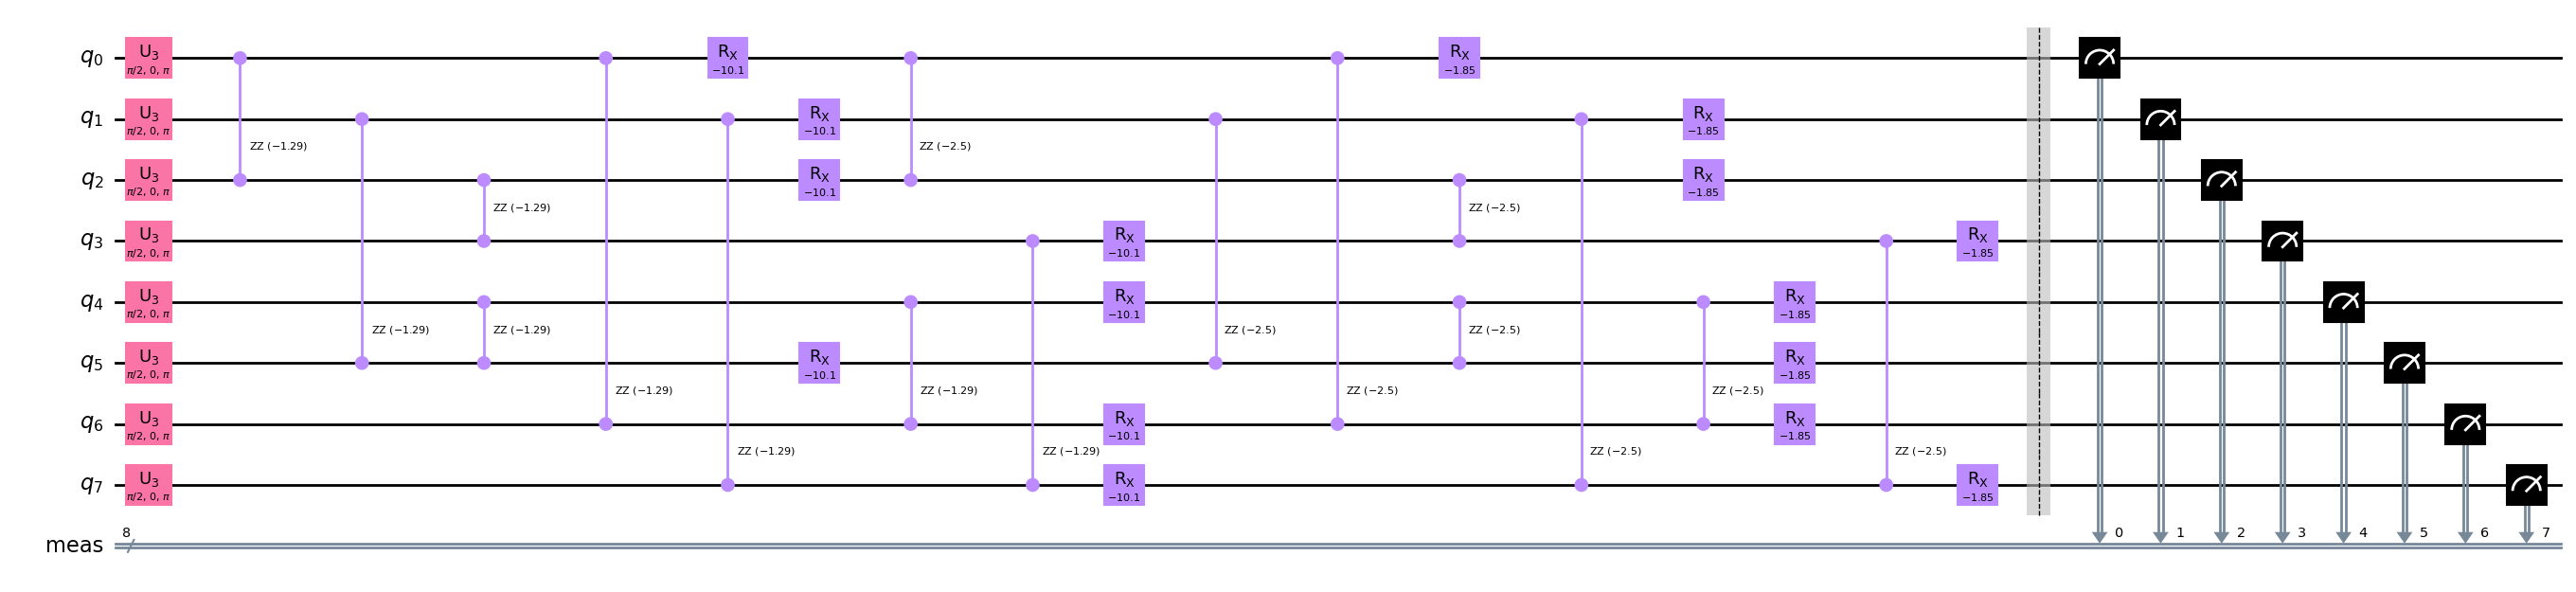

In [7]:
qc = qc.decompose().decompose()
qc.draw("mpl", fold=-1)

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
0.06666666666666667
13.5


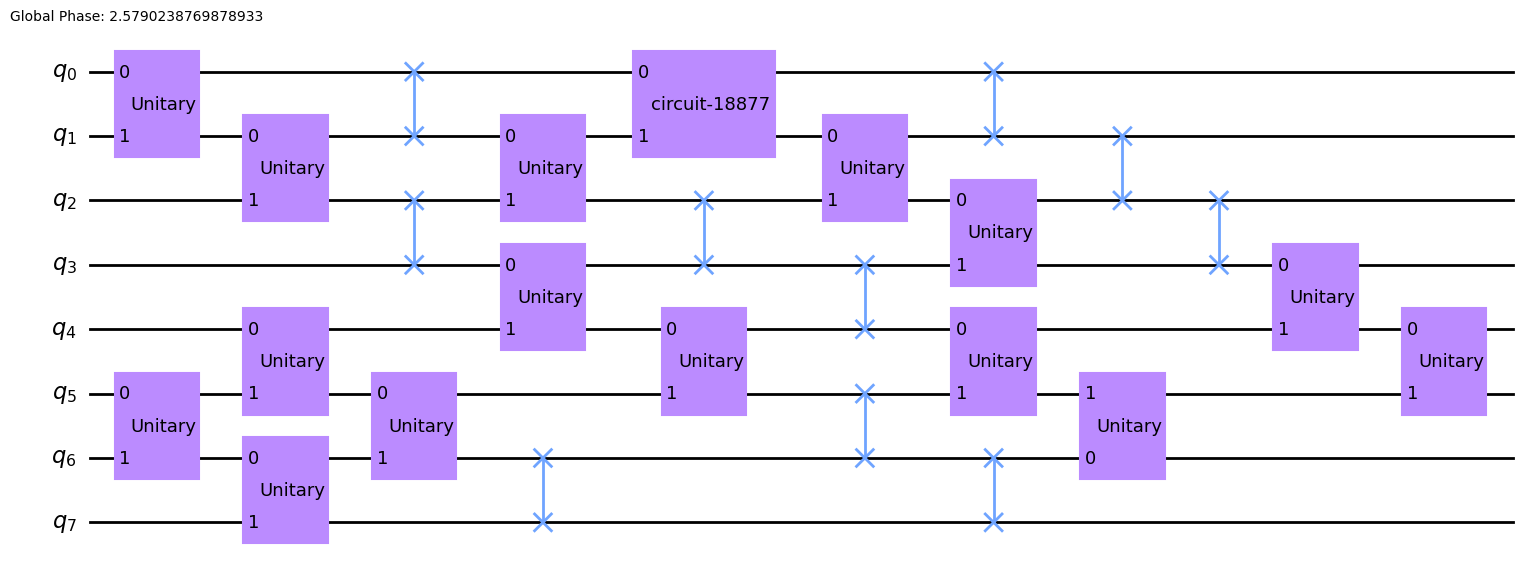

In [8]:
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from transpile_benchy.metrics.depth_metric import DepthMetric

runner = SabreMS(coupling_map, parallel=False, logger=transpile_benchy_logger)
metric = DepthMetric()
runner.append_metric_pass(metric)
transp = runner.run(qc)
print(runner.property_set["accepted_subs"])
print(runner.property_set["monodromy_depth"])
# display(runner.property_set['pre'].draw('mpl'))
# display(runner.property_set['pre2'].draw('mpl'))
display(runner.property_set["mid"].draw("mpl", fold=-1))
# display(runner.property_set['post'].draw('mpl'))
# display(transp.draw(output="mpl", fold=-1))

In [9]:
!pip install snakeviz

In [ ]:
%load_ext snakeviz

In [10]:
import cProfile

# Profile 'your_function' and write the result into 'my_profile.profile'
cProfile.run("runner.run(qc)", "my_profile.profile")

In [19]:
%snakeviz 'src/notebooks/my_profile.profile'

 
*** Profile stats marshalled to file '/tmp/tmp951zk0f0'.
Embedding SnakeViz in this document...
<function display at 0x7fab7b498dc0>


8.5


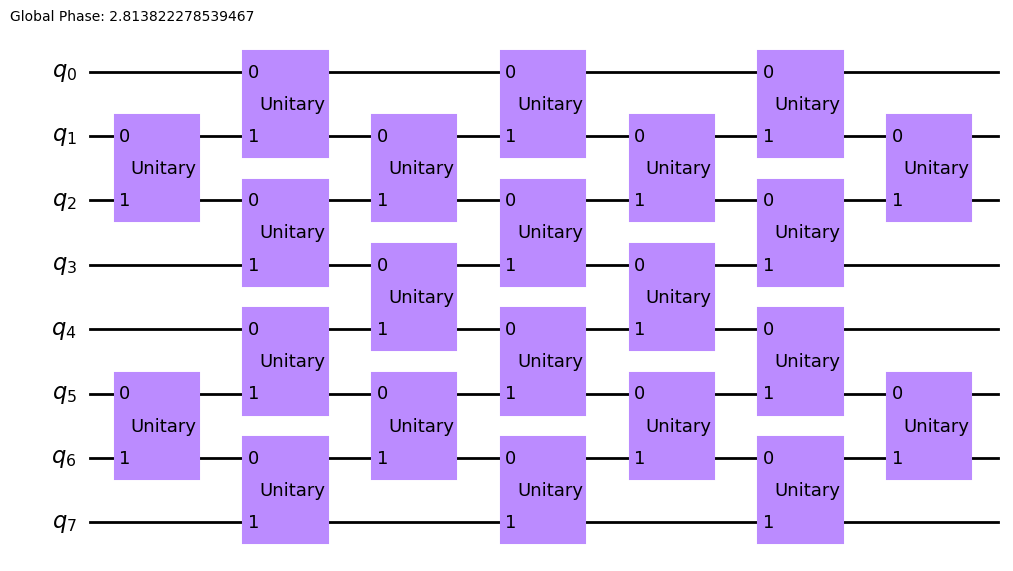

In [ ]:
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from transpile_benchy.metrics.depth_metric import DepthMetric

runner = QiskitLevel3(coupling_map)
metric = DepthMetric()
runner.append_metric_pass(metric)
transp = runner.run(qc)
print(runner.property_set["monodromy_depth"])
display(transp.draw(output="mpl", fold=-1))
# display(runner.property_set['post'].draw('mpl'))

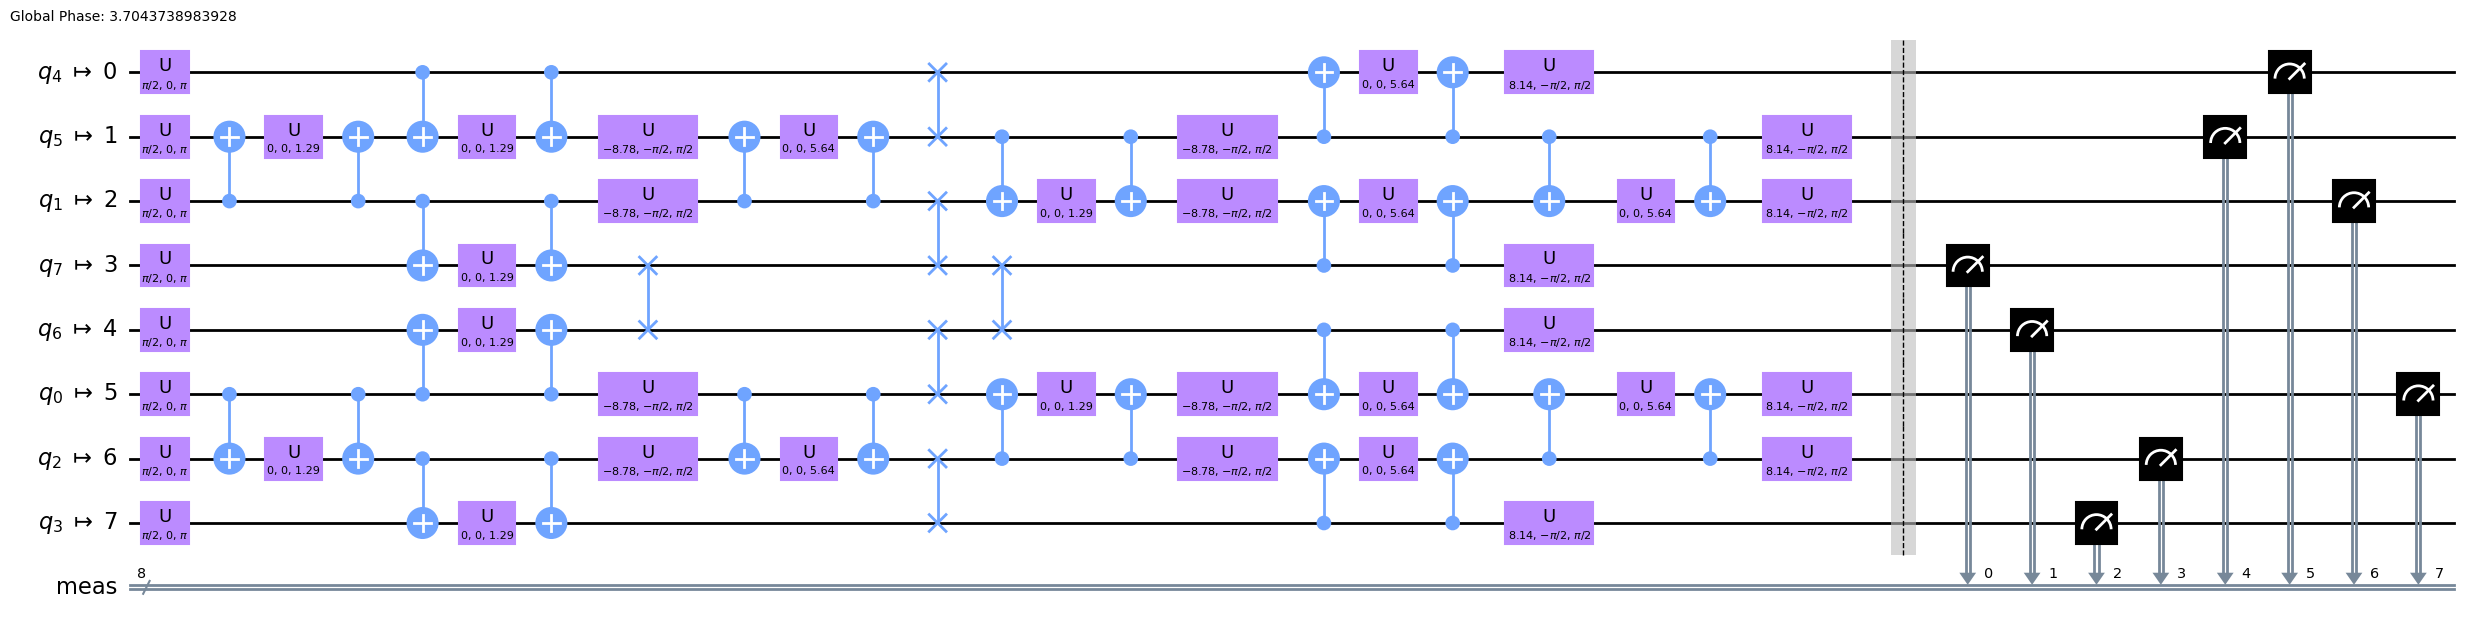

In [ ]:
from qiskit import transpile

transpile(
    qc, basis_gates=["u", "cx", "swap"], optimization_level=3, coupling_map=coupling_map
).draw("mpl", fold=-1)